In [1]:
import P_Cyg as pc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from matplotlib import rcParams
from astropy.stats import LombScargle
import astropy.constants as const
import astropy.units as u
paperdir = "C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Figures/Paper_Figures"
rcParams['text.usetex'] = True
rcParams['figure.figsize'] = [4,4]
rcParams['lines.color'] = 'black'
rcParams['font.size'] = 20
rcParams['font.family'] = 'serif'
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize']= 14
rcParams['ytick.labelsize']= 14

In [2]:
intrinsic_dir = "C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/intrinsic_pols/"
files = glob(intrinsic_dir+"*")
retfiles = [f    for f in files if f[72]=='o']
rfiles = [f    for f in files if f[72]=='r']
bfiles = [f    for f in files if f[72]=='b']
matched = []
for rf in rfiles:
    for bf in bfiles:
        if rf[64:69]==bf[64:69]:
            matched.append([rf,bf])
matched = np.array(matched)
mdfs = [[pd.read_csv(f[0]),pd.read_csv(f[1])]    for f in matched]
mdfs = [pd.concat([p[0],p[1][p[1].Wavelength < 6100]]).sort_values("Wavelength")    for p in mdfs]
rdfs = [pd.read_csv(f)    for f in files if f[72]=='r']
bdfs = [pd.read_csv(f)    for f in files if f[72]=='b']
retdfs = [pd.read_csv(f)     for f in retfiles]
alldfs = retdfs+mdfs
t = [float(f[64:69])    for f in retfiles] + [float(f[0][64:69])    for f in matched]
mt = np.array([float(f[0][64:69])    for f in matched])
mphaset = (mt/97)%1

In [3]:
# wl,wr = 6540,6600
# qs = np.array([np.mean(df.Q[(df.Wavelength > wl) & (df.Wavelength < wr)])   for df in alldfs])
# us = np.array([np.mean(df.U[(df.Wavelength > wl) & (df.Wavelength < wr)])   for df in alldfs])
# es = np.array([np.sqrt(np.sum(df.Error[(df.Wavelength > wl) & (df.Wavelength < wr)]**2))/
#                df.Error[(df.Wavelength > wl) & (df.Wavelength < wr)].size    
#                for df in alldfs])
# pol,pos = pc.polarization(qs,us)

In [4]:
bt = pd.read_csv("C:/Users/Keyan/Desktop/Science/Data/P-Cygni/Data/bigtable.txt")
qs,us,es = np.array(bt.ihq),np.array(bt.ihu),np.array(bt.he)
pol,pos = pc.polarization(qs,us)
t = bt.MJD
phaset = np.array((np.array(t)/97.25760002801046)%1)
mask = np.where(es < 0.05)

<ErrorbarContainer object of 3 artists>

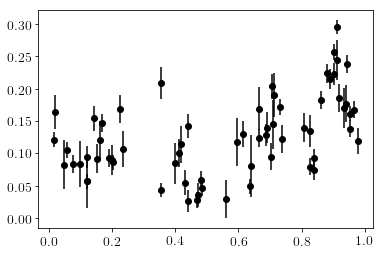

In [5]:
plt.errorbar(phaset[mask],np.array(pol)[mask],yerr=np.array(es)[mask],c='black',linestyle="None",marker='o')

1.4633068601478948e-05 97.25760002801046


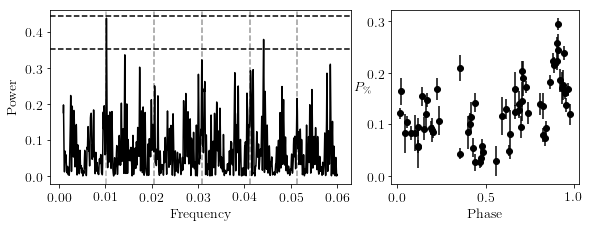

In [6]:
ls = LombScargle(np.array(t)[mask],np.array(pol)[mask],dy=np.array(es)[mask])
f = np.linspace(0.001,0.06,100000)
p = ls.power(f)
fals = [ls.false_alarm_level(i)    for i in [0.001,0.00001]]
bp = pc.find_best_period(f,p)
best_period = 1/bp
fa = ls.false_alarm_probability(max(p))

fig = plt.figure(figsize=[8,3])
ax = plt.subplot2grid((1,5),(0,0),colspan=3)
ax1 = plt.subplot2grid((1,5),(0,3),colspan=2)

ax.set_ylabel("Power",fontname="Garamond",fontsize=14)
ax.set_xlabel("Frequency",fontname="Garamond",fontsize=14)
ax.axvline(bp,linestyle='--',alpha=0.3)
ax.axvline(2*bp,linestyle='--',alpha=0.4)
ax.axvline(3*bp,linestyle='--',alpha=0.4)
ax.axvline(4*bp,linestyle='--',alpha=0.4)
ax.axvline(5*bp,linestyle='--',alpha=0.4)
ax.plot(f,p,color='black')
for f in fals:
    ax.axhline(f,linestyle='--')
print(fa,best_period)

ax1.errorbar(phaset[mask],pol[mask],yerr=es[mask],c='black',linestyle="None",marker='o')
ax1.set_ylabel(r"$P_\%$",rotation=0,fontname="Garamond",fontsize=14)
ax1.set_xlabel("Phase",fontname="Garamond",fontsize=14)

fig.tight_layout(pad=0)
plt.savefig(paperdir+"/periodicity.png",overwrite=True,dpi=300)
plt.show()

## Fake Data Cadence Test
To see if this periodicity is just do to how the data is sampled, we will create a simulated dataset with some known period, then sample it at the same intervals as the P Cyg data. If the 97 day period jumps out, then its probs not astrophysical

In [7]:
fake = lambda x,period: np.random.normal(loc=0.2*np.sin(((2*np.pi)/period)*x),scale=es)
x=np.linspace(0,1,1000)

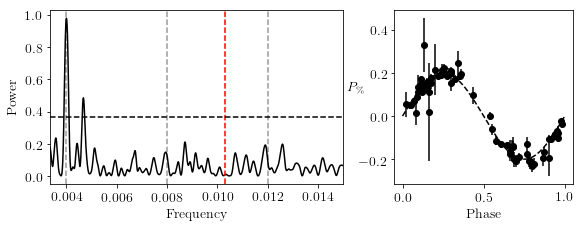

In [8]:
t = np.array(t)

data = fake(t,250)
ls = LombScargle(t,data,dy=es)
f = np.linspace(1/400,0.06,100000)
p = ls.power(f)
fals = [ls.false_alarm_level(i)    for i in [0.0001]]
bp = pc.find_best_period(f,p)
best_period = 1/bp
fa = ls.false_alarm_probability(max(p))
    
fig = plt.figure(figsize=[8,3])
ax1 = plt.subplot2grid((1,5),(0,0),colspan=3)
ax2 = plt.subplot2grid((1,5),(0,3),colspan=2)

ax1.axvline(bp,linestyle='--',alpha=0.4)
ax1.axvline((2*bp),linestyle='--',alpha=0.4)
ax1.axvline((3*bp),linestyle='--',alpha=0.4)
ax1.plot(f,p,color='black')
ax1.axvline(1/97,linestyle='--',c='red')
for f in fals:
    ax1.axhline(f,linestyle='--')
ax1.set_ylabel("Power",fontname="Garamond",fontsize=14)
ax1.set_xlabel("Frequency",fontname="Garamond",fontsize=14)
ax1.set_xlim(1/300,0.015)

phaset = (np.array(t)/best_period)%1 
ax2.errorbar(phaset,data,yerr=es,linestyle='None',color='black',marker='o')
ax2.plot(x,0.2*np.sin((2*np.pi)*x),color='black',linestyle='--')

ax2.set_ylabel(r"$P_\%$",rotation=0,fontname="Garamond",fontsize=14)
ax2.set_xlabel("Phase",fontname="Garamond",fontsize=14)
   
plt.tight_layout(pad=0)
plt.savefig(paperdir+"/periodicity_test.png",overwrite=True,dpi=300)

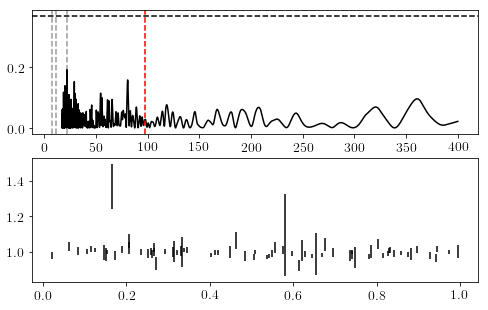

In [9]:
data = np.random.normal(loc=1,scale=es)
ls = LombScargle(t,data,dy=es)
f = np.linspace(1/400,0.06,100000)
p = ls.power(f)
fals = [ls.false_alarm_level(i)    for i in [0.0001]]
bp = pc.find_best_period(f,p)
best_period = 1/bp
fa = ls.false_alarm_probability(max(p))

fig,(ax1,ax2) = plt.subplots(2,figsize=[8,5])
ax1.axvline(1/bp,linestyle='--',alpha=0.4)
ax1.axvline(1/(2*bp),linestyle='--',alpha=0.4)
ax1.axvline(1/(3*bp),linestyle='--',alpha=0.4)
ax1.plot(1/f,p,color='black')
ax1.axvline(97,linestyle='--',c='red')
for f in fals:
    ax1.axhline(f,linestyle='--')
phaset = (np.array(t)/best_period)%1 
ax2.errorbar(phaset,data,yerr=es,linestyle='None',color='black')
plt.show()

In [10]:
GwenTable = pd.DataFrame({"MJD":t,
                         "% Polarization":pol,
                         "Position Angle [degrees]":pos,
                         "Error":es})

In [11]:
GwenTable.to_csv("C:/Users/Keyan/Desktop/Science/PCygTimeseries.txt",sep=":")

## Pfew Test
If the periodicity is in the line itself then it should pop out here, otherwise it is only in the continuum

In [12]:
pfew = pc.polarization(bt.pq,bt.pu)[0]

80.41513181836024 51.22411491527959


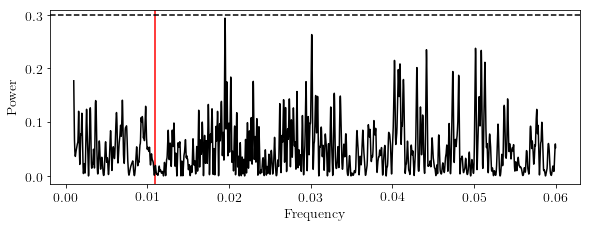

In [13]:
mask = np.where(es < 0.05)
ls = LombScargle(np.array(t)[mask],np.array(pfew)[mask],dy=np.array(es)[mask])
f = np.linspace(0.001,0.06,100000)
p = ls.power(f)
fals = [ls.false_alarm_level(i)    for i in [0.01]]
bp = pc.find_best_period(f,p)
best_period = 1/bp
fa = ls.false_alarm_probability(max(p))
fig,ax = plt.subplots(1,figsize=[8,3])

ax.set_ylabel("Power",fontname="Garamond",fontsize=14)
ax.set_xlabel("Frequency",fontname="Garamond",fontsize=14)
ax.axvline(0.011,color='r')
ax.plot(f,p,color='black')
for f in fals:
    ax.axhline(f,linestyle='--')
print(1/fa,best_period)

plt.tight_layout(pad=0)
plt.savefig(paperdir+"/pfew_periodicity.png",overwrite=True,dpi=300)

## Rotation

In [14]:
rv = (35 * u.km/u.s).to(u.m/u.s)
c = (2* np.pi * 76 * u.solRad).to(u.m)
time = c/rv
time.to(u.d)

<Quantity 109.8585031 d>